In [10]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.callbacks

from keras.datasets import mnist

In [11]:
def load_data(dataset):
    if dataset == "mnist":
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        x_train = np.load("Data/" + dataset + ".npy")
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    x_train = x_train.reshape(len(x_train), 784)
    return (x_train)

In [12]:
def build_1D_generator(rand_shape, output_shape):
    
    data_in = Input(shape=rand_shape, name="data_in")
    
    x = Dense(256, kernel_initializer=initializers.RandomNormal(stddev=0.02))(data_in)       
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Dense(512)(x)       
    x = LeakyReLU(alpha=0.2)(x)

    x = Dense(1024)(x)       
    x = LeakyReLU(alpha=0.2)(x)

    out = Dense(output_shape[0], activation='tanh')(x)
    
    generator = Model(inputs=[data_in], outputs=[out])
    generator.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    generator.summary()
    return generator

In [13]:
def build_1D_discriminator(input_shape):
    
    data_in = Input(shape=input_shape, name="data_in")
    
    x = Dense(1024, kernel_initializer=initializers.RandomNormal(stddev=0.02))(data_in)       
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Dense(512)(x)       
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Dense(256)(x)       
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    out = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=[data_in], outputs=[out])
    discriminator.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    discriminator.summary()
    return discriminator

# Build GAN

In [14]:
def build_gan(generator, discriminator, rand_shape):
    
    # set generation mode
    discriminator.trainable = False
    
    gan_input = Input(shape=rand_shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    
    gan = Model(inputs=[gan_input], outputs=[gan_output])
    gan.compile(loss="binary_crossentropy", optimizer="adadelta")
    
    return gan

# Train 1D GAN

In [15]:
def train_gan(dataset, rand_param_size=100, epochs=10, batch_size=32, show_img=True):
    np.random.seed(10)
    # Load data
    x_train = load_data(dataset)
    # Set shapes and stuff
    rand_shape = (rand_param_size, )
    output_shape = x_train.shape[1:]
    batch_count = int(x_train.shape[0] / batch_size)

    # Build models
    generator = build_1D_generator(rand_shape, output_shape)
    discriminator = build_1D_discriminator(output_shape)
    gan = build_gan(generator, discriminator, rand_shape)

    # Train for each epoch
    for i in range(1, epochs + 1):
        print('-'*15, 'Epoch %d' % i, '-'*15)
        # for each batch
        for j in tqdm(range(batch_count)):
            # build fake image
            noise = np.random.normal(0, 1, size=[batch_size, rand_param_size])
            generated_images = generator.predict(noise)
            # grab real images
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            # Build mixed dataset
            X = np.concatenate([image_batch, generated_images])
            # Build labels
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            # Discriminator train step
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            # Build new seeds and "real" labels
            seeds = np.random.normal(0, 1, size=[batch_size, rand_param_size])
            y_gen = np.ones(batch_size)
            # Generator train step
            discriminator.trainable = False
            gan.train_on_batch(seeds, y_gen)
    
    if show_img:
        # build fake images
        visu_seeds = np.random.normal(0, 1, size=[batch_size, rand_param_size])
        built_images = generator.predict(visu_seeds)
        built_images = built_images.reshape(built_images.shape[0], int(np.sqrt(built_images.shape[1])), int(np.sqrt(built_images.shape[1])))
        # plot generated images
        fig = plt.figure(figsize=(8, 8))
        columns = 4
        rows = batch_size / columns
        for i, img in enumerate(built_images):
            if i + 1 > 0 and i < columns * rows:
                fig.add_subplot(rows, columns, i+1)
                plt.imshow(img, cmap="Greys")
        plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_in (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
__________

100%|██████████| 1875/1875 [02:05<00:00, 15.10it/s]


--------------- Epoch 2 ---------------


100%|██████████| 1875/1875 [02:07<00:00, 14.65it/s]


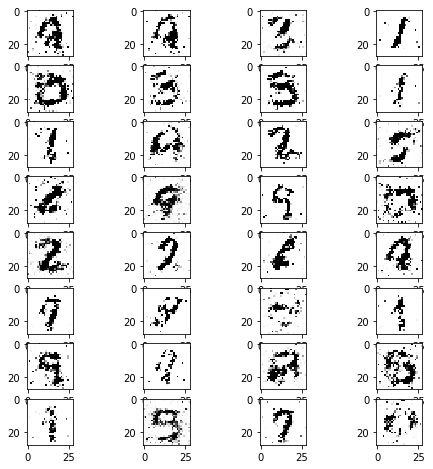

In [16]:
train_gan("mnist", rand_param_size=100, epochs=2, batch_size=32, show_img=True)

# 2D (WIP)

In [ ]:
def build_2D_generator(rand_shape, output_shape):
    pass

In [ ]:
def build_2D_discriminator(input_shape):
    
    data_in = Input(shape=input_shape, name="data_in")

    x = Convolution2D(filters=64, kernel_size=32, strides=2,
                padding='same', activation="relu", use_bias=False, 
                kernel_initializer=initializers.RandomNormal(stddev=0.02))(data_in)       
    x = BatchNormalization()(x)

    x = Convolution2D(filters=32, kernel_size=16, strides=2, padding='same', 
                      activation="relu", use_bias=False)(x)       
    x = BatchNormalization()(x)

    x = Convolution2D(filters=16, kernel_size=8, strides=2, padding='same', 
                      activation="relu", use_bias=False)(x)       
    x = BatchNormalization()(x)

    x = Flatten(name='flattened')(x)

    out = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=[data_in], outputs=[out])
    discriminator.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return discriminator